# Baseline: Linear Interpolation

## Load Libraries

In [52]:
from util import *
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (60.0, 48.0) # set default size of plots

## Load Data

In [53]:
""" Load data """
# img_folder = "data/kid-playing-insect"
# img_folder = "data/kid-conversation"
img_folder = "data/kid-swing"
imgs = [p[2] for p in walk(img_folder)][0]
prefix, postfix = imgs[0].split("-")[0], imgs[0].split(".")[1]
print("Total Images: {}".format(len(imgs)))
print("From:         {}".format(imgs[0]))
print("To:           {}".format(imgs[-1]))

Total Images: 42
From:         dasheng-14726.jpg
To:           dasheng-14767.jpg


## Set Parameters

In [54]:
gap = 6

assert gap%2==0, "gap must be an even number!"

In [55]:
"""
parse image index:
    dasheng-6298.jpg -> 6298
"""
def parse_img_index(s):
    return int(s.split("-")[1].split(".")[0])

def index_to_img(i):
    return "{}/{}-{}.{}".format(img_folder, prefix, base_index + i, postfix)

## Get Train Images and Ground Truth

In [56]:
base_index = parse_img_index(imgs[0])
to = parse_img_index(imgs[-1])+1 - len(imgs)%gap
num_intervals = (to-base_index)//gap 

print("Select Range:  {} -> {} | {} Intervals".format(base_index, to, num_intervals))

Select Range:  14726 -> 14768 | 7 Intervals


In [57]:
x_index = [i*gap for i in range(num_intervals)]
mid_index = [x + gap//2 for x in x_index]
X = [misc.imread(index_to_img(i)) for i in x_index]
y = [misc.imread(index_to_img(i)) for i in mid_index]  # ground truth
print("Image shape: {}".format(X[0].shape))

Image shape: (686, 1280, 3)


## Display Input

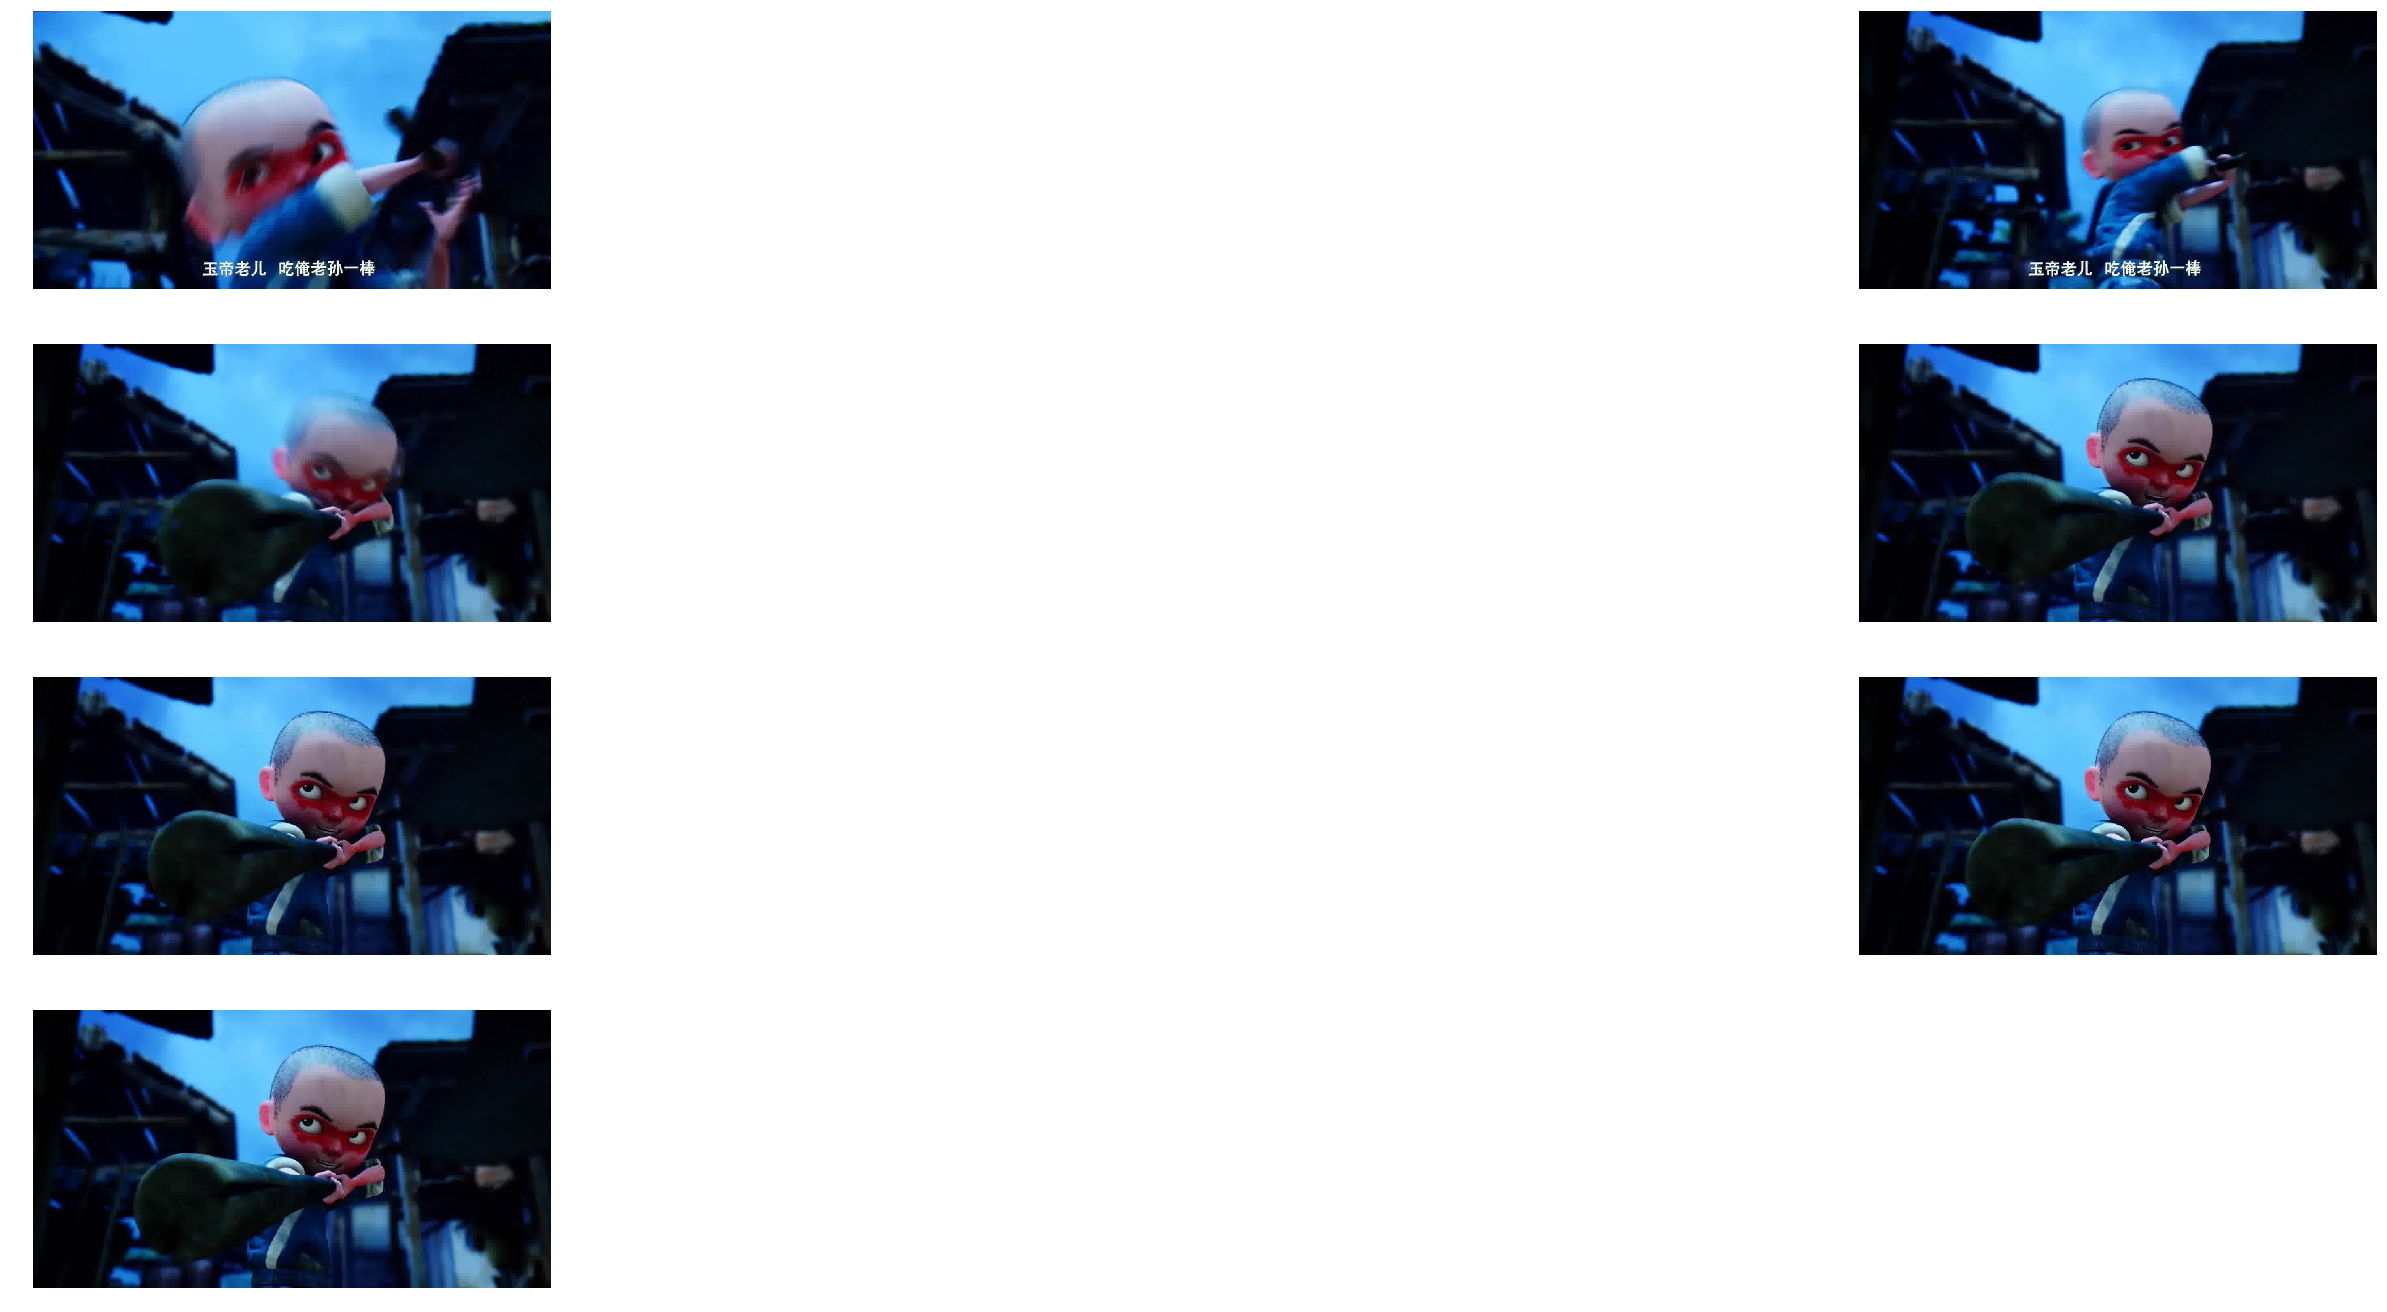

In [58]:
for i in range(len(X)):
    plt.subplot(train_size, 2, i+1)
    plt.imshow(X[i])
    plt.axis('off')

## Linear-interpolate Input Images

In [59]:
def avg_imges(x1, x2):
    return np.array([x1, x2]).mean(axis=0).astype('uint8')

In [60]:
interporlated = [avg_imges(X[i], X[i+1]) for i in range(len(X) - 1)]

## Compare

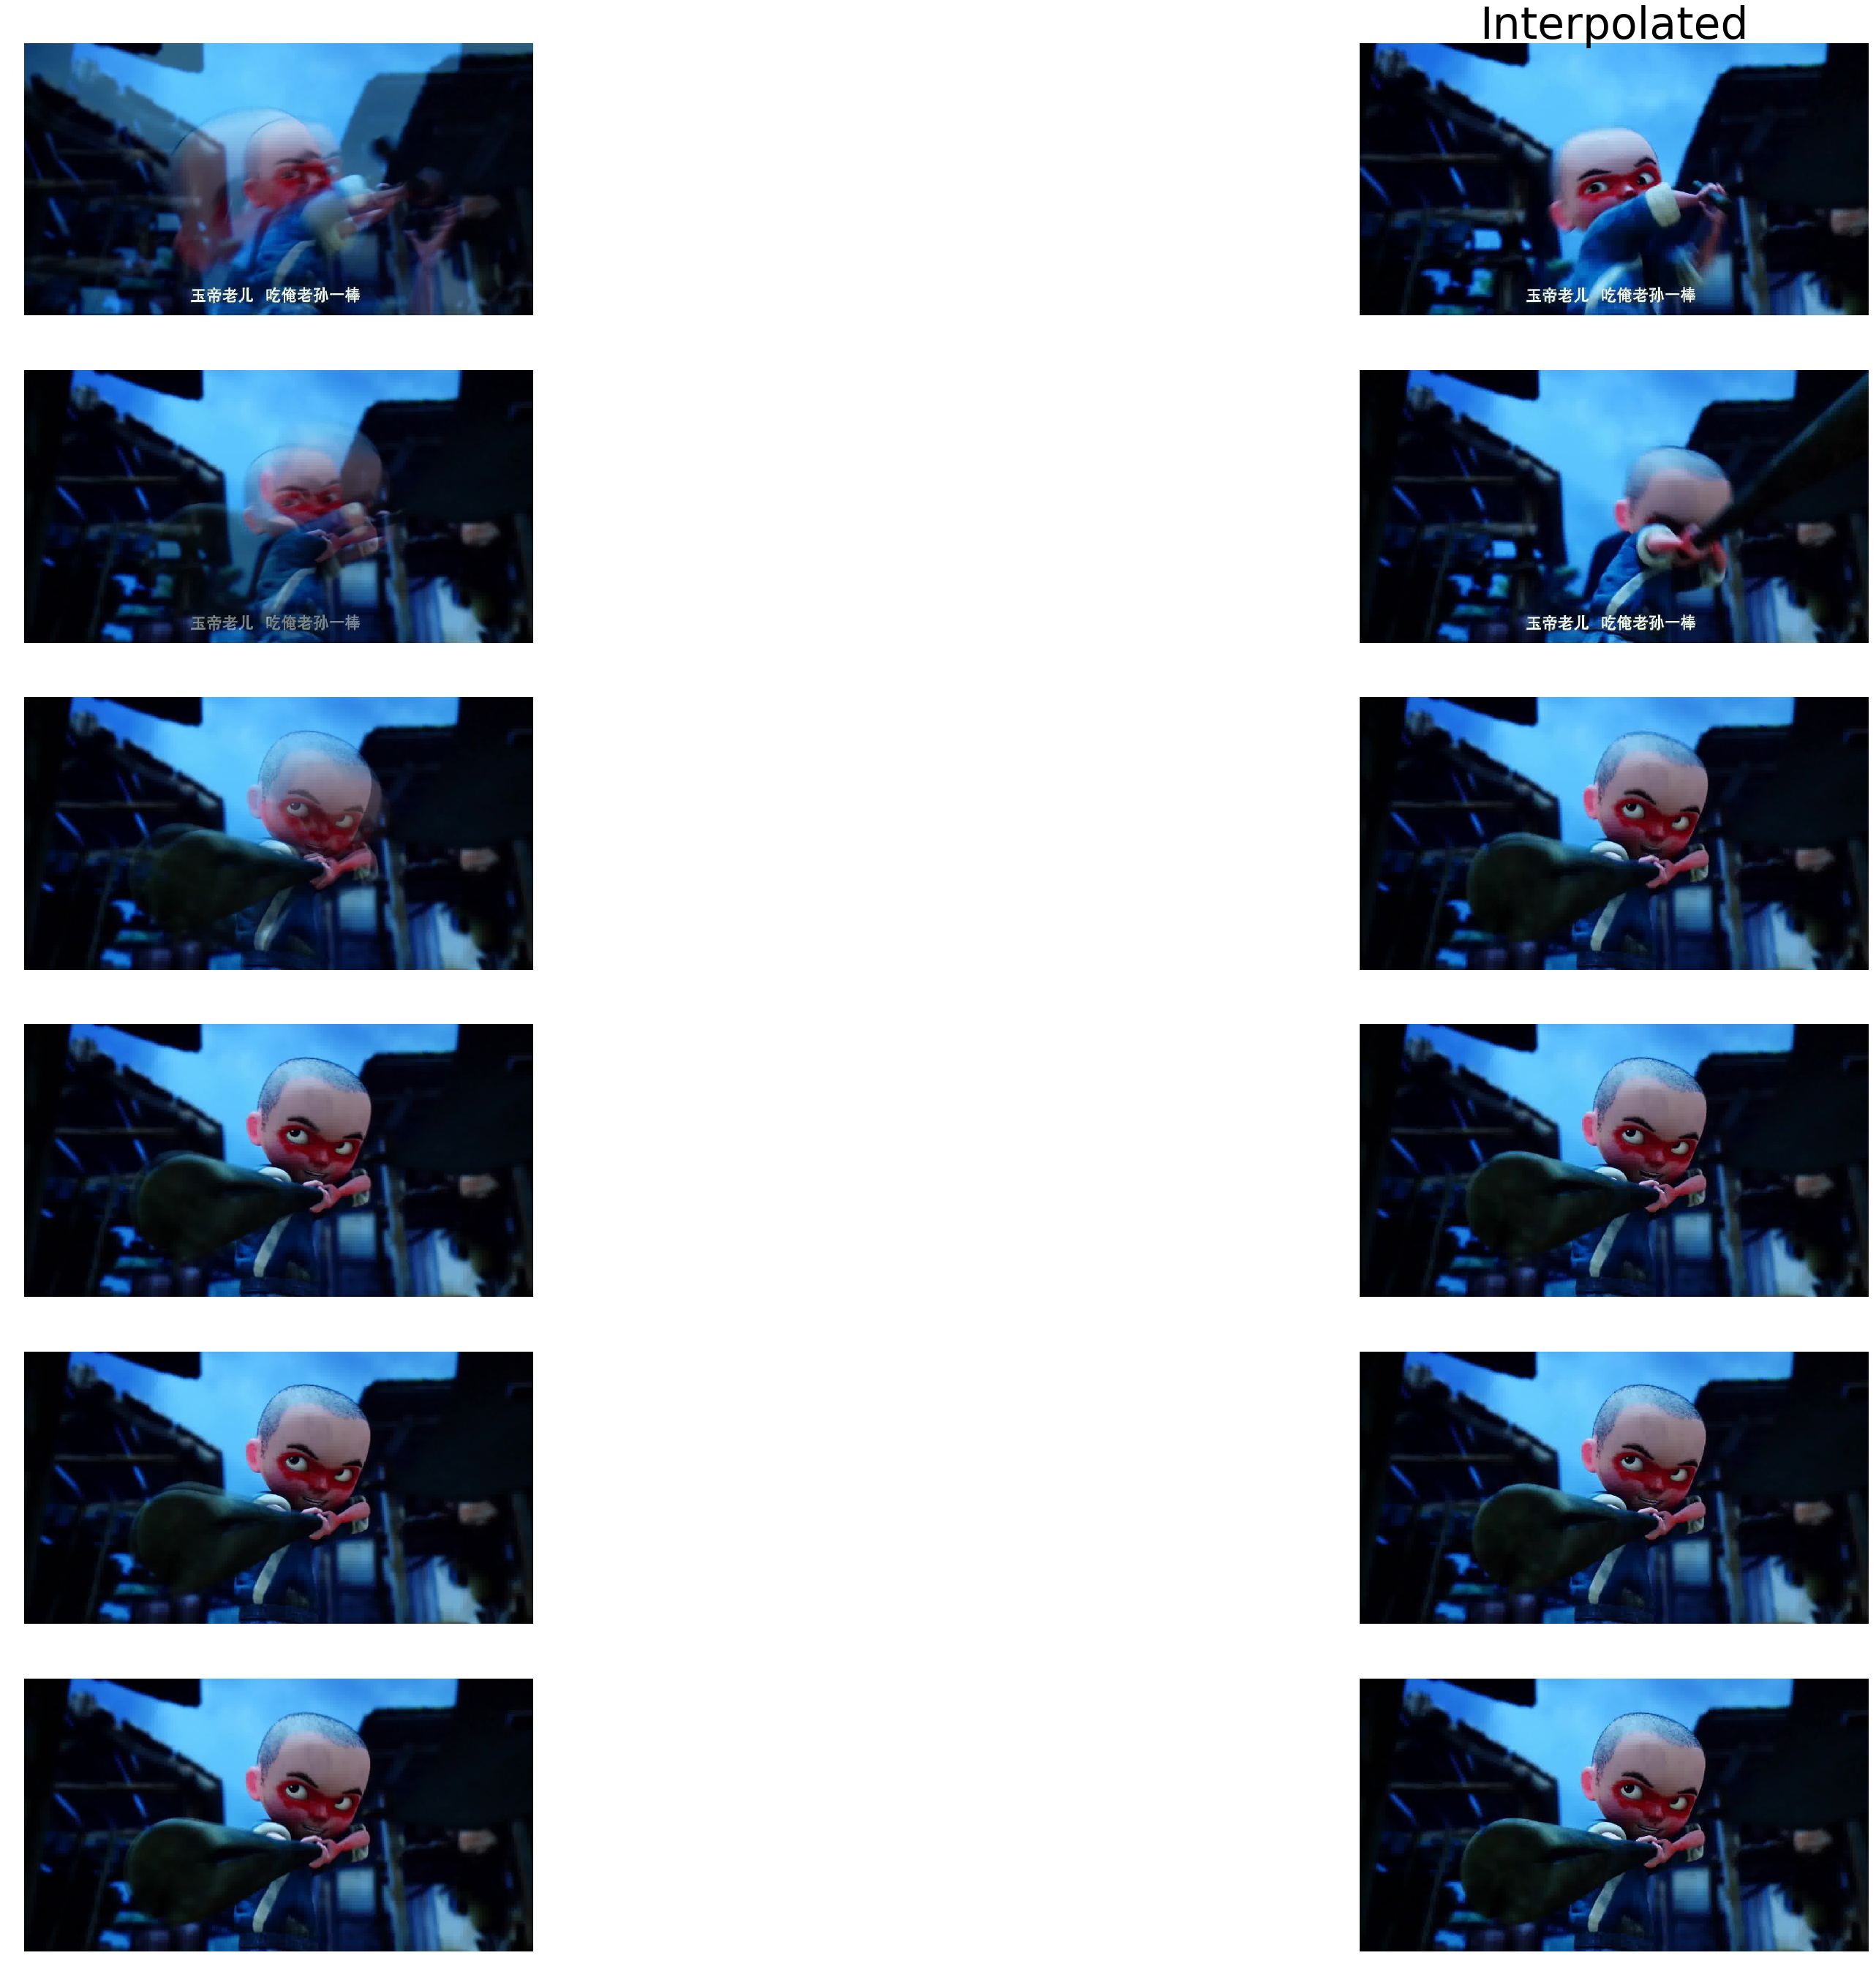

In [64]:
compare = list(zip(interporlated, y))
num_frames = len(compare)
for i in range(num_frames):

    gd, infer = compare[i]
    plt.subplot(num_frames, 2, i*2 + 2)
    plt.imshow(infer)
    plt.axis('off')
    if i == 0: plt.title("Interpolated", fontsize=60)
    plt.subplot(num_frames, 2, i*2 + 1)
    plt.imshow(gd)
    plt.axis('off')
    

## Loss

In [62]:
"""
pixel-wise L2 loss
"""
def get_loss(p1, p2):
    return np.linalg.norm(p1-p2)

In [63]:
loss = np.mean([get_loss(*c) for c in compare])

print("Loss: %.1f"%loss)

Loss: 245377.6
